## Импорт бибилиотек и функции

In [1]:
# импорт нужных бибилиотек
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

In [2]:
def plot_training_curves(history):
  loss_values = history.history['loss'] # ошибка на тренировочном наборе
  val_loss_values = history.history['val_loss'] # ошибка на валидационном наборе
  acc_values = history.history['accuracy']  # точность на тренировочном наборе
  val_acc_values = history.history['val_accuracy'] # точность на валидационном наборе

  epochs_x = range(1, len(loss_values) + 1) # количество эпох обучения

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # график значения функции потерь на каждой эпохе
  ax1.plot(epochs_x, loss_values, 'b-o', label='Ошибка обучения')
  ax1.plot(epochs_x, val_loss_values, 'r-o', label='Ошибка валидации')
  ax1.set_title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  ax1.set_xlabel('Эпохи', fontsize=12)
  ax1.set_ylabel('Значение ошибки', fontsize=12)
  ax1.grid()
  ax1.legend()

  # график значения точности на каждой эпохе
  ax2.plot(epochs_x, acc_values, 'b-o', label='Точность обучения')
  ax2.plot(epochs_x, val_acc_values, 'r-o', label='Точность валидации')
  ax2.set_title('Точность при обучении и валидации', fontsize=14, fontweight="bold")
  ax2.set_xlabel('Эпохи', fontsize=12)
  ax2.set_ylabel('Значение точности', fontsize=12)
  ax2.grid()
  ax2.legend()

  return

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cmap='Greens', cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=14, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

# Функция для подсчета метрик модели классификации
def generate_preformance_scores(y_true, y_pred, y_probabilities):

  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                y_pred,
                                                                                average="weighted")

  print(f'accuracy_score:\t\t{model_accuracy:.4f}')
  print(f'precision_score:\t{model_precision:.4f}')
  print(f'recall_score:\t\t{model_recall:.4f}')
  print(f'f1_score:\t\t{model_f1:.4f}')

  preformance_scores = {
      'accuracy_score': model_accuracy,
      'precision_score': model_precision,
      'recall_score': model_recall,
      'f1_score': model_f1,
  }

  return preformance_scores

## Загрузка набора данных

In [3]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Oct 31 05:05 kaggle.json


In [5]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [6]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d fantacher/neu-metal-surface-defects-data

 78% 45.0M/57.4M [00:00<00:00, 113MB/s]
100% 57.4M/57.4M [00:00<00:00, 114MB/s]


## Чтение данных

In [ ]:
# разархивирование данных
!unzip "/content/neu-metal-surface-defects-data.zip" -d "/content/metal_surface_defects"

In [9]:
# прописываем пути до папок с изображениями
train_dir = '/content/metal_surface_defects/NEU Metal Surface Defects Data/train'
test_dir = '/content/metal_surface_defects/NEU Metal Surface Defects Data/test'
valid_dir = '/content/metal_surface_defects/NEU Metal Surface Defects Data/valid'

## Создание наборов данных

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, # масштабирование данных
                                   rotation_range=20, # диапазон градусов для произвольных поворотов
                                   width_shift_range=0.1, # диапазон горизонатльного сдвига
                                   height_shift_range=0.1, # диапазон вертикального сдвига
                                   horizontal_flip=True) # горизонтальный поворот

test_datagen = ImageDataGenerator(rescale=1./255) # масштабирование данных

train_generator = train_datagen.flow_from_directory(train_dir, # папка с изображениями
                                              target_size=(200, 200), # размер изображения
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = test_datagen.flow_from_directory(valid_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [12]:
# посмотрим на названия классов
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(f"Названия классов: {class_names}")

Названия классов: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


In [15]:
# функция для получения изображения
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]

    return image, label_name

# функция для визуализации изображения с названием класса
def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

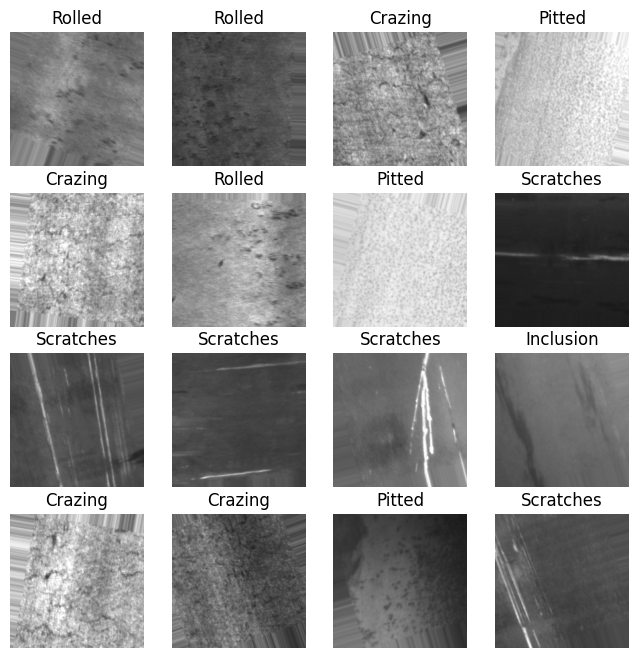

In [35]:
# визуализация изображений с названиями классов
sample_images(train_generator, nrows=4, ncols=4)

## Обучение моделей

### Первая модель

In [36]:
model1 = keras.Sequential([
    layers.Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)), # объявляем размер входных данных и задаем первый сверточный слой
    layers.MaxPooling2D((2, 2)), # слой пулинга
    layers.Flatten(), # выравнивающий слой
    layers.Dense(6 ,activation='softmax') # выходной слой с 6 нейронами так как задача многоклассовой классификации, ФА softmax
])

In [37]:
model1.summary() # информация о модели

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 199, 199, 32)      416       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 313632)            0         
                                                                 
 dense_2 (Dense)             (None, 6)                 1881798   
                                                                 
Total params: 1882214 (7.18 MB)
Trainable params: 1882214 (7.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
model1.compile(loss="categorical_crossentropy", # функция ошибки
             metrics=["accuracy"], # метрика
             optimizer="rmsprop") # оптимизатор

history = model1.fit(train_generator,
                    epochs=20,
                    batch_size=32,
                    validation_data=valid_generator)

Epoch 1/20
52/52 [==============================] - 24s 462ms/step - loss: 18.0313 - accuracy: 0.2132 - val_loss: 2.6231 - val_accuracy: 0.3333
Epoch 2/20
52/52 [==============================] - 16s 316ms/step - loss: 1.8612 - accuracy: 0.4179 - val_loss: 1.3858 - val_accuracy: 0.4861
Epoch 3/20
52/52 [==============================] - 26s 506ms/step - loss: 1.1252 - accuracy: 0.5894 - val_loss: 0.9429 - val_accuracy: 0.4722
Epoch 4/20
52/52 [==============================] - 21s 405ms/step - loss: 0.9956 - accuracy: 0.6292 - val_loss: 0.4820 - val_accuracy: 0.9306
Epoch 5/20
52/52 [==============================] - 22s 417ms/step - loss: 0.8412 - accuracy: 0.7132 - val_loss: 0.4429 - val_accuracy: 0.9028
Epoch 6/20
52/52 [==============================] - 18s 342ms/step - loss: 0.8844 - accuracy: 0.7089 - val_loss: 0.4430 - val_accuracy: 0.8472
Epoch 7/20
52/52 [==============================] - 16s 304ms/step - loss: 0.8028 - accuracy: 0.7053 - val_loss: 0.4686 - val_accuracy: 0.888

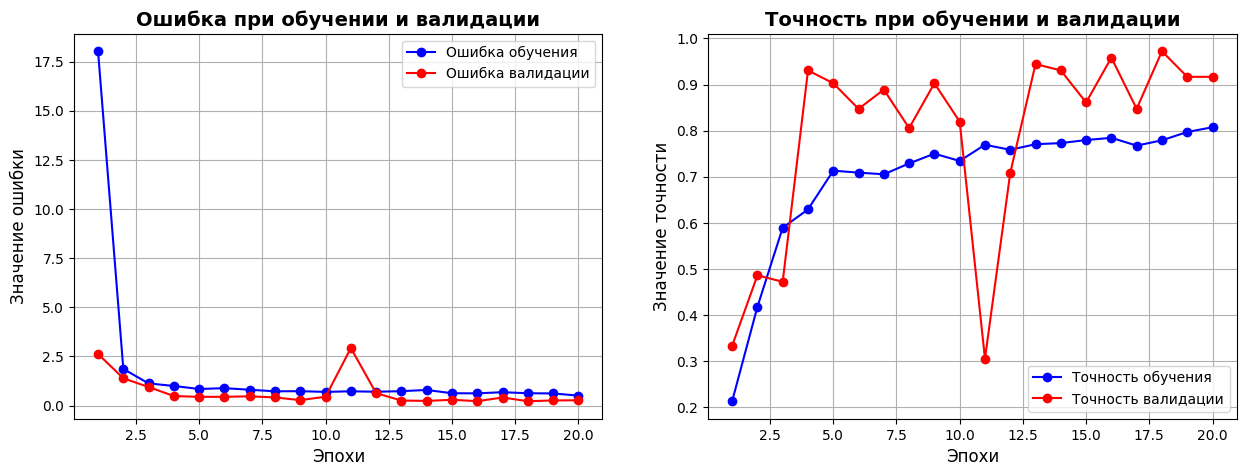

In [42]:
# графики для визуализации процесса обучения
plot_training_curves(history)

**Вывод**: по графикам процесса обучения видно, что модель не переобучается, так как ошибка на обучающих и на валидационных данных стремится к 0.

In [43]:
y_predicted_prob = model1.predict(test_generator) # обучения модели на тестовом наборе

3/3 [==============================] - 0s 21ms/step


In [44]:
y_predicted = tf.argmax(y_predicted_prob, axis=1)

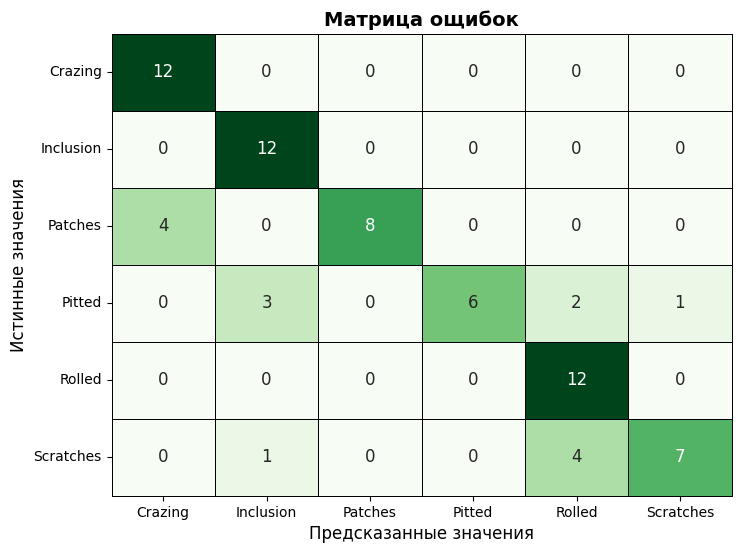

In [45]:
plot_confusion_matrix(
    test_generator.classes,
    y_predicted,
    figsize=(8, 6),
    classes=class_names)

In [46]:
model1_performance = generate_preformance_scores(test_generator.classes,
                                                 y_predicted,
                                                 y_predicted_prob)

accuracy_score:		0.7917
precision_score:	0.8403
recall_score:		0.7917
f1_score:		0.7802


Попробуем изменить оптимизатор на adam и обучить модель еще раз

### Вторая модель

In [47]:
model1 = keras.Sequential([
    layers.Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)), # объявляем размер входных данных и задаем первый сверточный слой
    layers.MaxPooling2D((2, 2)), # слой пулинга
    layers.Flatten(), # выравнивающий слой
    layers.Dense(6 ,activation='softmax') # выходной слой с 6 нейронами так как задача многоклассовой классификации, ФА softmax
])

In [48]:
model1.summary() # информация о модели

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 199, 199, 32)      416       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 313632)            0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1881798   
                                                                 
Total params: 1882214 (7.18 MB)
Trainable params: 1882214 (7.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
model1.compile(loss="categorical_crossentropy", # функция ошибки
             metrics=["accuracy"], # метрика
             optimizer="adam") # оптимизатор

history = model1.fit(train_generator,
                    epochs=20,
                    batch_size=32,
                    validation_data=valid_generator)

Epoch 1/20
52/52 [==============================] - 17s 298ms/step - loss: 5.0416 - accuracy: 0.2271 - val_loss: 1.4235 - val_accuracy: 0.2917
Epoch 2/20
52/52 [==============================] - 16s 303ms/step - loss: 1.2902 - accuracy: 0.4487 - val_loss: 1.0733 - val_accuracy: 0.5556
Epoch 3/20
52/52 [==============================] - 16s 300ms/step - loss: 0.9201 - accuracy: 0.6697 - val_loss: 0.8447 - val_accuracy: 0.5694
Epoch 4/20
52/52 [==============================] - 16s 299ms/step - loss: 0.7922 - accuracy: 0.7138 - val_loss: 0.6873 - val_accuracy: 0.7500
Epoch 5/20
52/52 [==============================] - 17s 335ms/step - loss: 0.6958 - accuracy: 0.7597 - val_loss: 0.6992 - val_accuracy: 0.7222
Epoch 6/20
52/52 [==============================] - 16s 299ms/step - loss: 0.6039 - accuracy: 0.7826 - val_loss: 0.5340 - val_accuracy: 0.8333
Epoch 7/20
52/52 [==============================] - 15s 298ms/step - loss: 0.6067 - accuracy: 0.7893 - val_loss: 0.4330 - val_accuracy: 0.9028

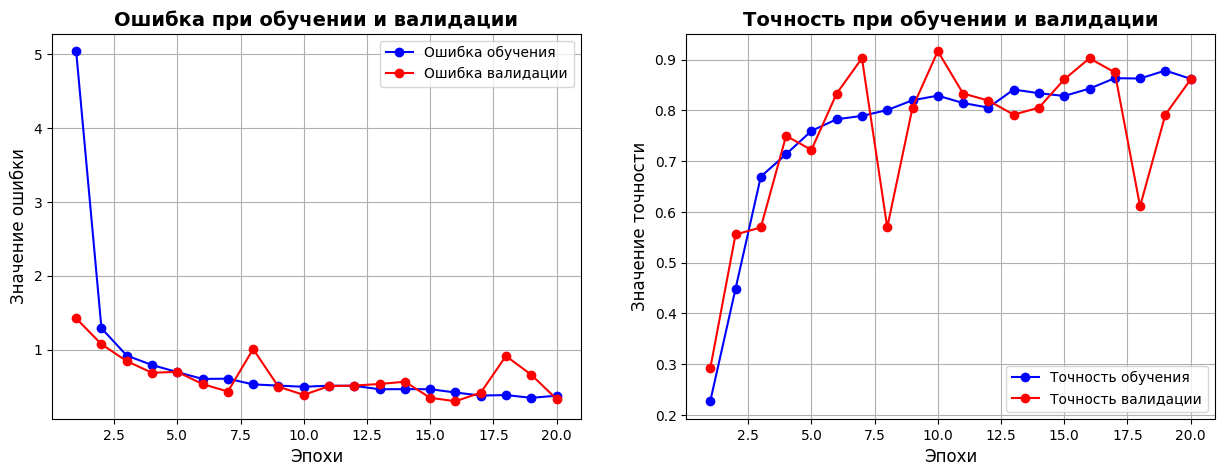

In [50]:
# графики для визуализации процесса обучения
plot_training_curves(history)

In [51]:
y_predicted_prob = model1.predict(test_generator) # обучения модели на тестовом наборе

3/3 [==============================] - 0s 36ms/step


In [52]:
y_predicted = tf.argmax(y_predicted_prob, axis=1)

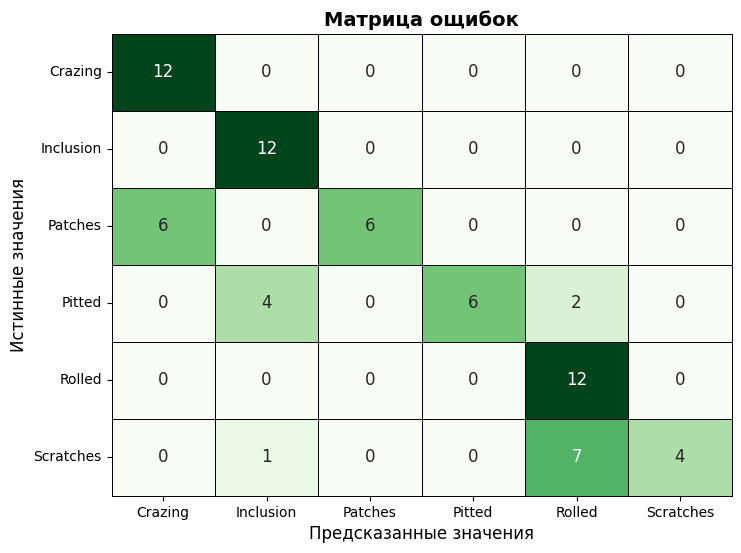

In [53]:
plot_confusion_matrix(
    test_generator.classes,
    y_predicted,
    figsize=(8, 6),
    classes=class_names)

In [54]:
model2_performance = generate_preformance_scores(test_generator.classes,
                                                 y_predicted,
                                                 y_predicted_prob)

accuracy_score:		0.7222
precision_score:	0.8240
recall_score:		0.7222
f1_score:		0.6980


Исходя из метрик обучения можно сделать вывод, что модель обучается лучше при использовании оптимизатора adam. Попробуем углубить сеть и увеличить количество нейронов в слоях

### Третья модель

In [63]:
# Model layers
model3 = keras.Sequential([
    layers.Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6 ,activation='softmax')
])

In [64]:
model3.summary() # информация о модели

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 199, 199, 32)      416       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 98, 98, 64)        8256      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 128)       32896     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 24, 24, 128)      

In [65]:
model3.compile(loss="categorical_crossentropy",
             metrics=["accuracy"],
             optimizer="rmsprop")

history = model3.fit(train_generator,
                    epochs=20,
                    batch_size=32,
                    validation_data=valid_generator)

Epoch 1/20
52/52 [==============================] - 19s 342ms/step - loss: 1.9160 - accuracy: 0.2240 - val_loss: 1.5730 - val_accuracy: 0.3194
Epoch 2/20
52/52 [==============================] - 16s 315ms/step - loss: 1.4898 - accuracy: 0.4191 - val_loss: 1.7524 - val_accuracy: 0.2778
Epoch 3/20
52/52 [==============================] - 18s 337ms/step - loss: 1.3129 - accuracy: 0.5115 - val_loss: 0.9299 - val_accuracy: 0.6528
Epoch 4/20
52/52 [==============================] - 16s 316ms/step - loss: 1.1882 - accuracy: 0.5586 - val_loss: 0.8195 - val_accuracy: 0.7639
Epoch 5/20
52/52 [==============================] - 18s 336ms/step - loss: 1.0249 - accuracy: 0.6214 - val_loss: 0.6127 - val_accuracy: 0.8472
Epoch 6/20
52/52 [==============================] - 16s 310ms/step - loss: 0.8976 - accuracy: 0.6775 - val_loss: 0.4602 - val_accuracy: 0.8889
Epoch 7/20
52/52 [==============================] - 17s 323ms/step - loss: 0.7654 - accuracy: 0.7319 - val_loss: 0.6194 - val_accuracy: 0.7917

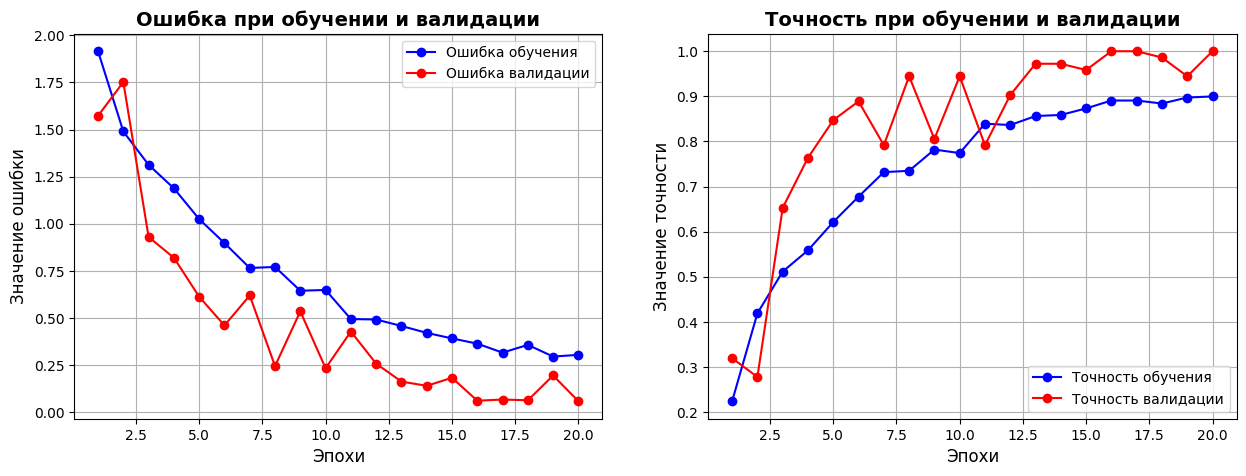

In [66]:
# графики для визуализации процесса обучения
plot_training_curves(history)

In [67]:
y_predicted_prob = model3.predict(test_generator) # обучения модели на тестовом наборе

3/3 [==============================] - 0s 22ms/step


In [68]:
y_predicted = tf.argmax(y_predicted_prob, axis=1)

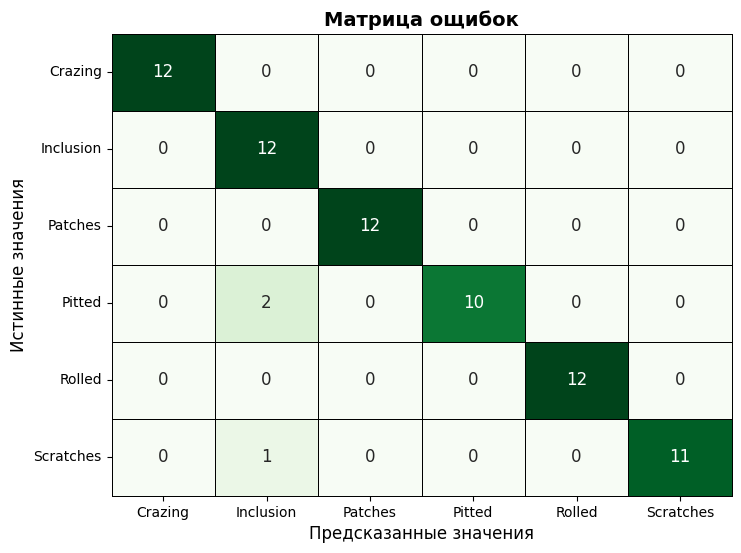

In [69]:
plot_confusion_matrix(
    test_generator.classes,
    y_predicted,
    figsize=(8, 6),
    classes=class_names)

In [70]:
model3_performance = generate_preformance_scores(test_generator.classes,
                                                          y_predicted,
                                                          y_predicted_prob)

accuracy_score:		0.9583
precision_score:	0.9667
recall_score:		0.9583
f1_score:		0.9591


In [71]:
# сведем результаты работы всех моделей в таблицу
performance_df = pd.DataFrame({
    'model_1': model1_performance,
    'model_2': model2_performance,
    'model_3': model3_performance
}).T

performance_df

,accuracy_score,precision_score,recall_score,f1_score
model_1,0.791667,0.840278,0.791667,0.780159
model_2,0.722222,0.823996,0.722222,0.698032
model_3,0.958333,0.966667,0.958333,0.959084


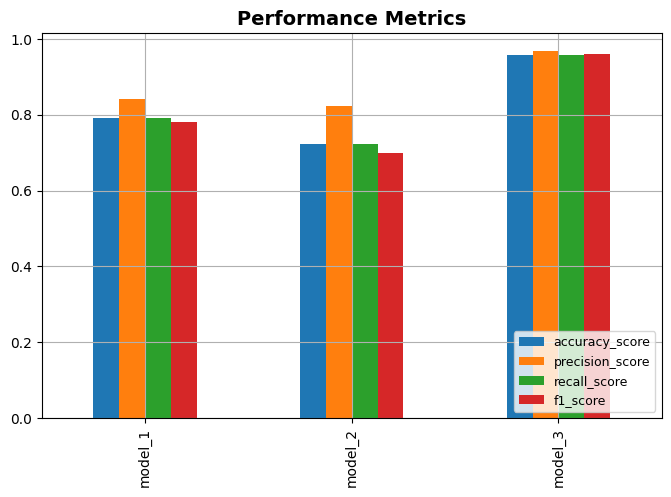

In [83]:
performance_df.plot(kind="bar", figsize=(8, 5))
plt.title('Performance Metrics', fontsize=14, fontweight="bold");
plt.legend(loc=4, fontsize=9)
plt.grid()

Исходя из метрик качества видно, что более глубокая модель работает лучше всего